In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import copy
from scipy.signal import find_peaks, resample
from icecream import ic
from collections import OrderedDict

from neurolib.models.aln import ALNModel
#from neurolib.models.aln import ALNModel_SaveSteps
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func  
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import os
import sys


sys.path.insert(0, '..')
from prc_funcs import *
from functions import *
    

import matplotlib.colors as mcolors

colors = mcolors.TABLEAU_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
colrs = [name for hsv, name in by_hsv]

#hide
import logging
logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

BASE_PATH = "../../../../" # need to go back from default hdf path "./data/hdf"
HDF_PATH = BASE_PATH + "Data/"

## Big BoxSearch Plot with Frequencies from old run :)

In [3]:
def evalf():
    pass

mue = [1.]
mui = [1.]
parameters = ParameterSpace({"mue_ext_mean": mue,
                             "mui_ext_mean": mui})

search = BoxSearch(evalFunction = evalf,
                   parameterSpace=parameters,
                   filename=HDF_PATH+'moreBifurcation_with_delays.hdf')

INFO:root:Number of processes: 4
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/moreBifurcation_with_delays.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 1
MainProcess root INFO     BoxSearch: Environment initialized.


In [4]:
search.loadResults()

MainProcess root INFO     Loading results from ./data/hdf/../../../../Data/moreBifurcation_with_delays.hdf
MainProcess root INFO     Analyzing trajectory results-2020-12-10-11H-34M-11S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/moreBifurcation_with_delays.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2020-12-10-11H-34M-11S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Processed 25078 nodes in 0m20s (1253.73 nodes/s).
MainProcess pypet.storageservice.HDF5StorageService INFO     Processed 63438 nodes in 0m40s (1585.73 nodes/s).
MainProcess pypet.storageservic

In [5]:
dfResults = search.dfResults

Text(0.5, 0.98, 'LC Frequency')

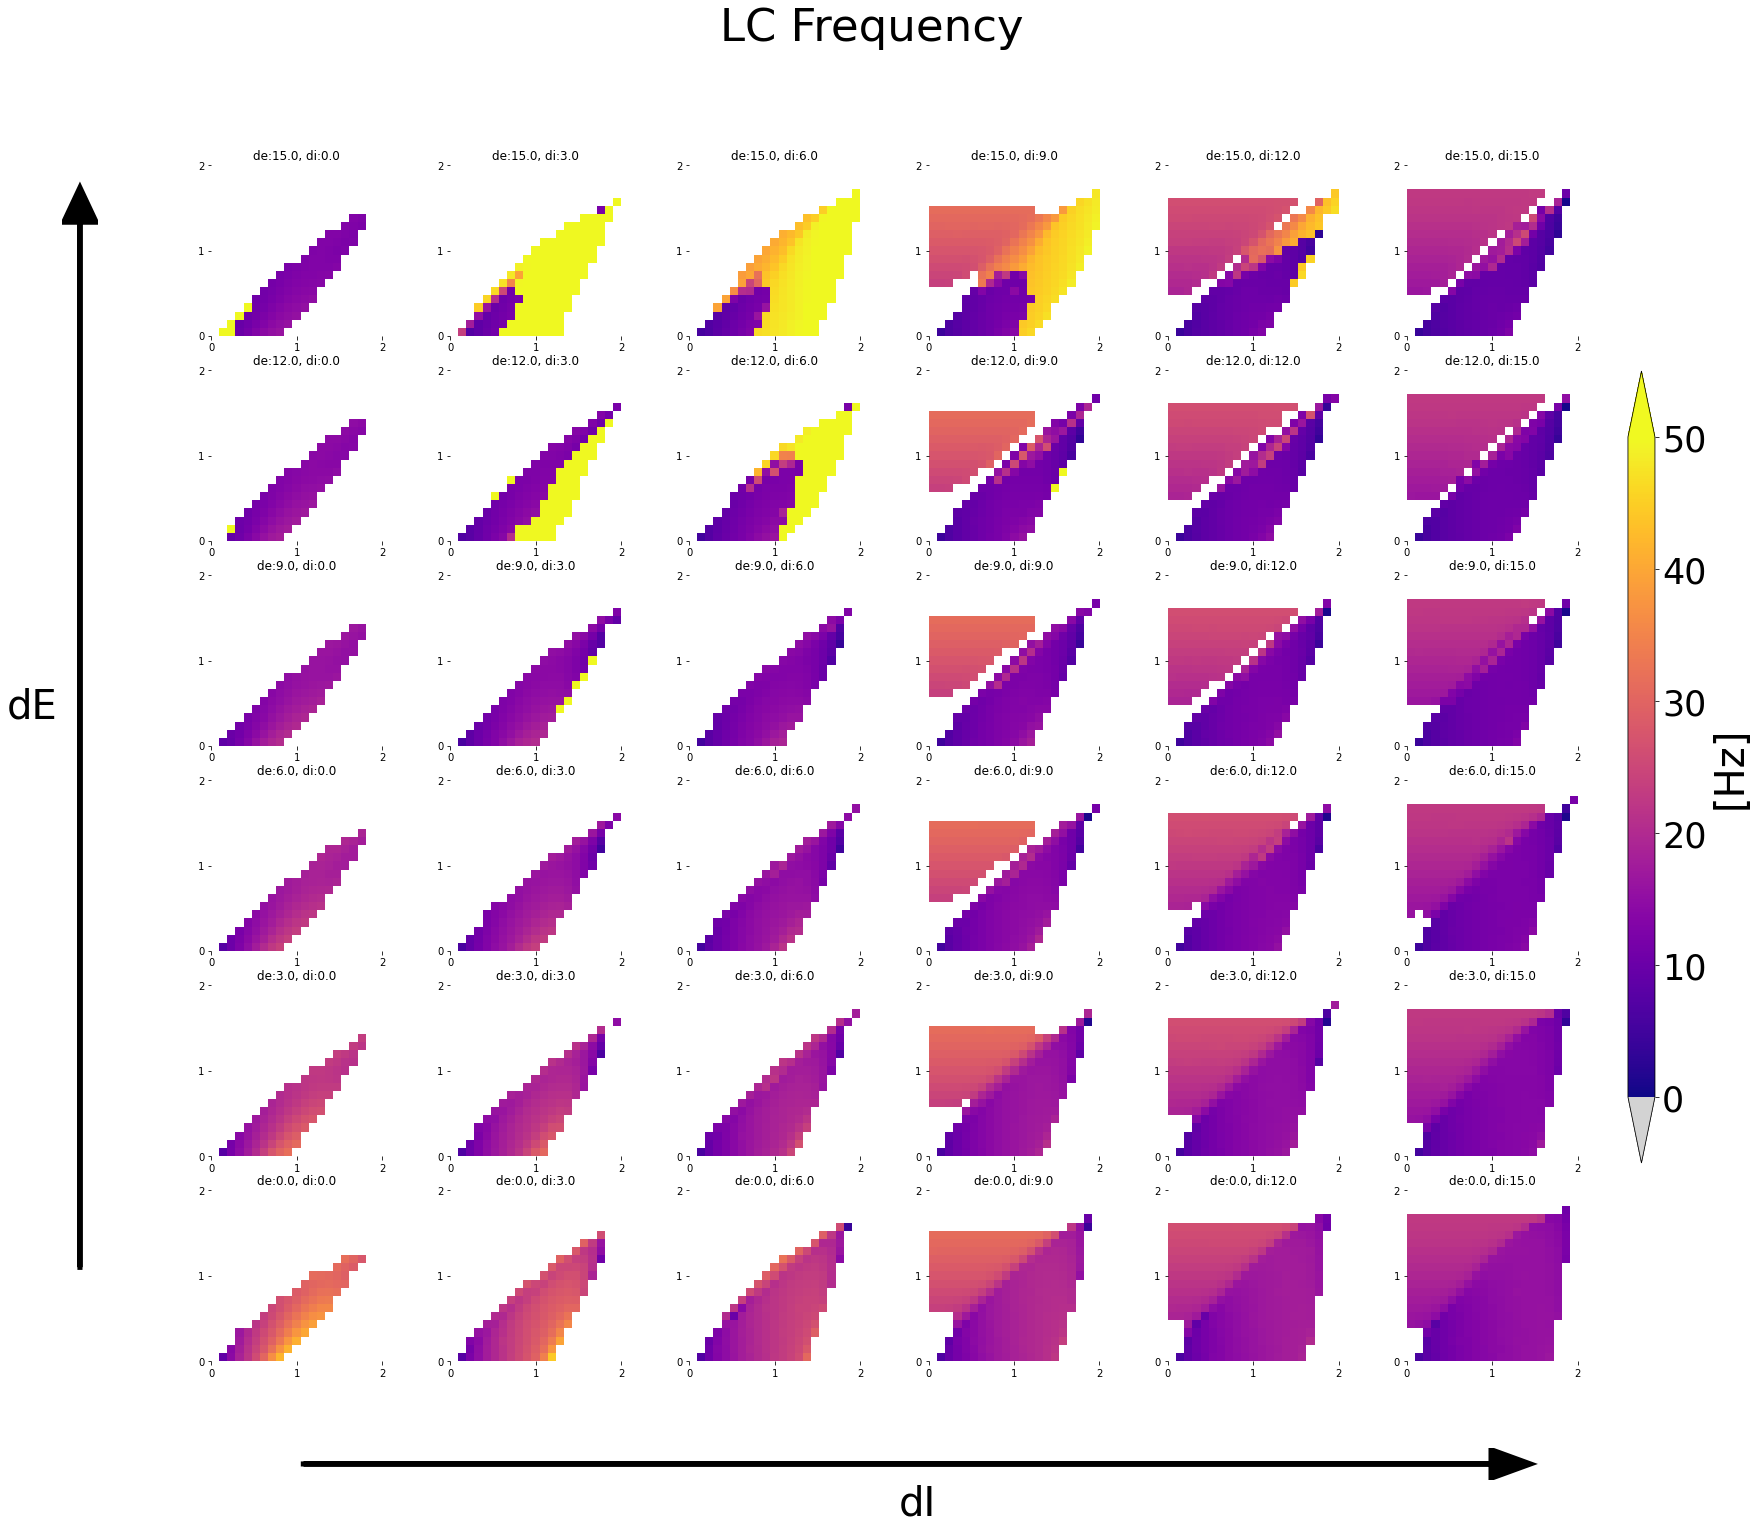

In [6]:
plt.rcParams['image.cmap'] = 'plasma'

length_exc = len(dfResults['de'].drop_duplicates())
dups_exc = dfResults.pivot_table(index=['de'], aggfunc='size').values[0]/length_exc
#print(dups_exc.values[0])
length_inh = len(dfResults['di'].drop_duplicates())
dups_inh = dfResults.pivot_table(index=['di'], aggfunc='size').values[0]/length_inh
fig, axs = plt.subplots(length_exc,length_inh,figsize=(25,22))
#f = plt.figure(figsize=(10,3))

for i,ax in enumerate(fig.axes):
    x = dfResults.de[(len(fig.axes)-1 - i) * dups_exc]
    y = dfResults.di[i*dups_inh]
    ax.set_title("de:{0:.3}, di:{1:.3}".format(x,y))
    df = dfResults[(dfResults.de == x)&(dfResults.di == y)]
    masked_array = np.ma.masked_where(df.pivot_table(values='state', index = 'mui_ext_mean', columns='mue_ext_mean') != 0.0,
                                      df.pivot_table(values='lc_freq', index = 'mui_ext_mean', columns='mue_ext_mean'))
    cmap = matplotlib.cm.plasma
    cmap.set_under(color='lightgrey')

    img = ax.imshow(masked_array, \
       extent = [min(search.dfResults.mue_ext_mean), max(search.dfResults.mue_ext_mean),
                 min(search.dfResults.mui_ext_mean), max(search.dfResults.mui_ext_mean)], origin='lower',vmin=0,vmax=50)
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1,2])
    ax.set(frame_on=False)
    #ax.set_xlabel("Input to E [mV/ms]")
    #ax.set_ylabel("Input to I [mV/ms]")
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes('right', size='5%', pad=0.05)
    #cbar = fig.colorbar(img, cax=cax, orientation='vertical',label='LC Frequency [Hz]')#,ticks=np.arange(0, 1.0, 0.1))
    #cbar.ax.set_yticklabels([r"{0:.2} $\pi$".format(i) for i in np.arange(0, 1.0, 0.1)])#cbar.set_clim(0,0.5)
    #cbar.ax.set_yticklabels(["down","LC","up"])#cbar.set_clim(0,0.5)

    #ax.axis('off')
#fig.subplots_adjust(left=0.1, bottom=-0.3)

## yaxis
yaxis_ax = fig.add_axes([0.05, 0.15, 0.02, 0.75])
yaxis_ax.arrow(0.5, 0, 0, 0.9, head_width=0.5, head_length=0.03, fc='k', ec='k',lw=5)
yaxis_ax.set_ylabel("dE", size=40, rotation=0, ha="right")
yaxis_ax.set_xticks([])
yaxis_ax.set_yticks([])
yaxis_ax.set(frame_on=False)    

## xaxis
xaxis_ax = fig.add_axes([0.15, 0.05 , 0.75, 0.02])
xaxis_ax.arrow(0, 0.5, 0.9, 0, head_width=0.5, head_length=0.03, fc='k', ec='k',lw=5)
xaxis_ax.set_xlabel("dI", size=40)
xaxis_ax.set_xticks([])
xaxis_ax.set_yticks([])
xaxis_ax.set(frame_on=False)  

cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
cbar = fig.colorbar(img, cax=cbar_ax,extend="both",extendfrac=0.1)#extendrect=True
cbar.ax.set_ylabel("[Hz]",size=40)
cbar.ax.tick_params(labelsize=35)

plt.suptitle("LC Frequency",size=45)
#fig.set_figheight(25)
#plt.tight_layout()
#plt.savefig(HOME_PATH+"Plots/Bifurcation/Frequency_big2.pdf",resolution=10000)

## now with my style

In [7]:
for i in search.dfResults.index:
    if search.dfResults['state'][i] != 0.0:
        search.dfResults.loc[i,'frequency'] = -1
    else:
        search.dfResults.loc[i,'frequency'] = search.dfResults['lc_freq'][i]

In [8]:
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

length_exc = len(dfResults['de'].drop_duplicates())
dups_exc = dfResults.pivot_table(index=['de'], aggfunc='size').values[0]/length_exc
#print(dups_exc.values[0])
length_inh = len(dfResults['di'].drop_duplicates())
dups_inh = dfResults.pivot_table(index=['di'], aggfunc='size').values[0]/length_inh
fig, axs = plt.subplots(length_exc,length_inh,figsize=(12,12))
#f = plt.figure(figsize=(10,3))

for i,ax in enumerate(fig.axes):
    y = dfResults.de[(len(fig.axes)-1 - i) * dups_exc]
    x = dfResults.di[i*dups_inh]
    #ax.set_title("de:{0:.3}, di:{1:.3}".format(x,y))
    df = dfResults[(dfResults.de == x)&(dfResults.di == y)]
    #masked_array = np.ma.masked_where(df.pivot_table(values='state', index = 'mui_ext_mean', columns='mue_ext_mean') != 0.0,
    #                                  df.pivot_table(values='lc_freq', index = 'mui_ext_mean', columns='mue_ext_mean'))
    cmap = matplotlib.cm.plasma
    cmap.set_under(color='lightgrey', alpha=0.5)

    img = ax.imshow(df.pivot_table(values='frequency', index = 'mui_ext_mean', columns='mue_ext_mean'), 
       extent = [min(search.dfResults.mue_ext_mean), max(search.dfResults.mue_ext_mean),
                 min(search.dfResults.mui_ext_mean), max(search.dfResults.mui_ext_mean)], origin='lower',vmin=0,vmax=35)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(frame_on=False)
    #ax.set_xlabel("Input to E [mV/ms]")
    #ax.set_ylabel("Input to I [mV/ms]")
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes('right', size='5%', pad=0.05)
    #cbar = fig.colorbar(img, cax=cax, orientation='vertical',label='LC Frequency [Hz]')#,ticks=np.arange(0, 1.0, 0.1))
    #cbar.ax.set_yticklabels([r"{0:.2} $\pi$".format(i) for i in np.arange(0, 1.0, 0.1)])#cbar.set_clim(0,0.5)
    #cbar.ax.set_yticklabels(["down","LC","up"])#cbar.set_clim(0,0.5)

    #ax.axis('off')
axs[5,0].set_xticks([0,1,2])
axs[5,0].set_yticks([0,1,2])
axs[5,0].set_xlabel(r"$\mu_E$ [mV/ms]")
axs[5,0].set_ylabel(r"$\mu_I$ [mV/ms]")
#fig.subplots_adjust(left=0.1, bottom=-0.3)
plt.subplots_adjust(wspace=0.02, hspace=0.1)

## xaxis
xaxis_ax = fig.add_axes([0.12, 0.06, 0.78, 0.01])
#xaxis_ax.arrow(0, 0.5, 0.8, 0, head_width=0.02, head_length=0.02, fc='k', ec='k',lw=2)
xaxis_ax.set_xlabel(r"$d_E$ [ms]", size=17)
xaxis_ax.set_yticks([])
xaxis_ax.set_xticks([0.088, 0.255, 0.42, 0.59, 0.76, 0.92])
xaxis_ax.set_xticklabels(['0', '3', '6', '9', '12', '15'], size=15)
xaxis_ax.tick_params(bottom=False)
xaxis_ax.spines["top"].set_visible(False)
xaxis_ax.spines["right"].set_visible(False)
xaxis_ax.spines["left"].set_visible(False)
xaxis_ax.spines["bottom"].set_linewidth(3)

## yaxis
yaxis_ax = fig.add_axes([0.07, 0.12, 0.01, 0.76])
#yaxis_ax.arrow(0.5, 0, 0, 0.9, head_width=0.01, head_length=0.03, fc='k', ec='k',lw=2)
yaxis_ax.set_ylabel(r"$d_I$ [ms]", size=17, rotation=90, ha="right")
yaxis_ax.set_xticks([])
yaxis_ax.set_yticks([0.085, 0.25, 0.42, 0.585, 0.755, 0.925])
yaxis_ax.set_yticklabels(['0', '3', '6', '9', '12', '15'], size=15)
yaxis_ax.tick_params(left=False)
yaxis_ax.spines["top"].set_visible(False)
yaxis_ax.spines["right"].set_visible(False)
yaxis_ax.spines["bottom"].set_visible(False)
yaxis_ax.spines["left"].set_linewidth(3)


cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
cbar = fig.colorbar(img, cax=cbar_ax,extend="both",extendfrac=0.06)#extendrect=True
cbar.ax.set_ylabel("[Hz]",size=17)
cbar.ax.tick_params(labelsize=15)
cbar.ax.tick_params(right=False)

#fig.tight_layout()
#plt.suptitle("LC Frequency",size=45)
#fig.set_figheight(25)
#plt.tight_layout()
#plt.savefig(HOME_PATH+"Plots/Bifurcation/Frequency_big2.pdf",resolution=10000)
#fig.savefig("Pics/LC_Freqs_all_new2.pdf")